In [ ]:
# Load required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Load datasets
train_path = 'fraudTrain.csv'
test_path = 'fraudTest.csv'
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [25]:
# Data preprocessing
df_combined = pd.concat([df_train, df_test], axis=0)

# Rename columns for better readability
new_feature_names = ['index', 'transaction_time', 'account_number', 'merchant_name', 'category',
       'transaction_amount', 'first_name', 'last_name', 'gender', 'street', 'city', 'state', 'zip',
       'client_latitude', 'client_longitude', 'city_population', 'job', 'birthday', 'transaction_number', 'unix_time',
       'merchant_latitude', 'merchant_longitude', 'is_fraud']
df_combined.columns = new_feature_names

In [27]:
# Convert transaction_time from string to datetime type. Add transaction date, hour, month to combined dataframe
df_combined['transaction_time'] = pd.to_datetime(df_combined['transaction_time'])
df_combined['transaction_date'] = df_combined['transaction_time'].dt.strftime('%Y-%m-%d')
df_combined['transaction_hour'] = df_combined['transaction_time'].dt.strftime('%H')
df_combined['transaction_month'] = df_combined['transaction_time'].dt.strftime('%m')

# Convert birthday from string to datetime type. Add 'age' feature to combined dataframe
df_combined['birthday'] = pd.to_datetime(df_combined['birthday'])
df_combined['age'] = ((df_combined['transaction_time'] - df_combined['birthday']).dt.days / 365.25).astype(int)

In [28]:
# Calculate transaction distance
distance_trans_longitude = df_combined['merchant_longitude'] - df_combined['client_longitude']
distance_trans_lattitude = df_combined['merchant_latitude'] - df_combined['client_latitude']
distance_trans = np.sqrt(distance_trans_longitude**2 + distance_trans_lattitude**2)
df_combined['transaction_distance'] = distance_trans

In [29]:
# Age interval function
def age_interval(x):
    if x < 20: return "Less than 20" 
    elif 20 <= x < 30: return "Between 20 and 30"
    elif 30 <= x < 40: return "Between 30 and 40"
    elif 40 <= x < 50: return "Between 40 and 50"
    elif 50 <= x < 60: return "Between 50 and 60"
    else: return "Larger than 60"

df_combined['age_intervals'] = df_combined['age'].map(age_interval)
df_combined['gender'] = df_combined['gender'].map(lambda x: "Male" if x == 'M' else "Female")


In [30]:
# Split back into train and test
train_samples_len = df_train.shape[0]
df_train_preprocessed = df_combined.iloc[:train_samples_len, :]
df_test_preprocessed = df_combined.iloc[train_samples_len:,:]

# Save preprocessed data
df_train_preprocessed.to_csv('df_train_preprocessed.csv', index=False)
df_test_preprocessed.to_csv('df_test_preprocessed.csv', index=False)

In [31]:
# Load preprocessed data
df = pd.read_csv('df_train_preprocessed.csv')
df_fraud = df[df['is_fraud']==1]
age_order = ['Less than 20', 'Between 20 and 30', 'Between 30 and 40', 
             'Between 40 and 50', 'Between 50 and 60', 'Larger than 60']

# Demographic Analysis
Gender Analysis

   gender   count  Number of fraud  Fraud ratio
0  Female  709863             3735         0.53
1    Male  586812             3771         0.64


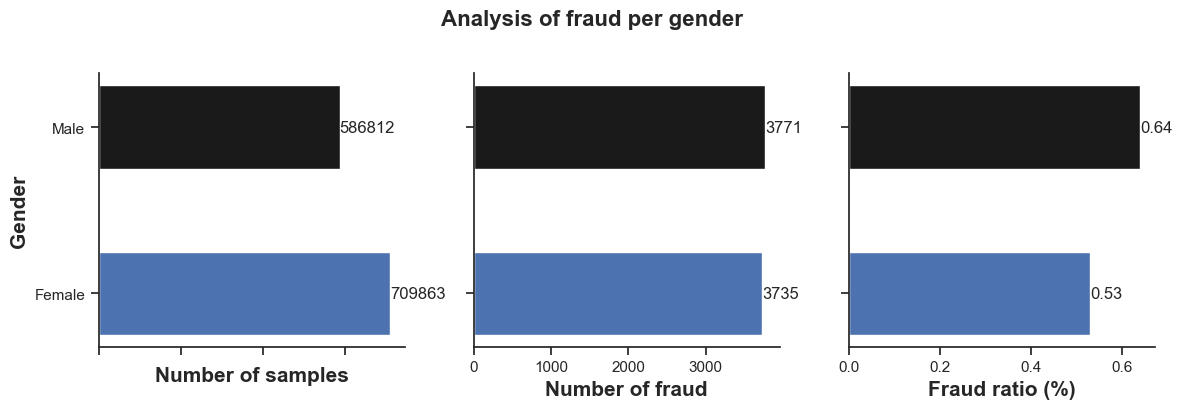

In [46]:
# Gender vs Fraud analysis
df_gender_is_fraud = df[['gender', 'is_fraud']].groupby(['gender']).agg(['count', 'sum', 'mean'])
df_gender_is_fraud.columns = ['count', 'Number of fraud', 'Fraud ratio']
df_gender_is_fraud.reset_index(inplace=True)
df_gender_is_fraud["Fraud ratio"] = df_gender_is_fraud["Fraud ratio"].apply(lambda x: round(x*100, 2))
print(df_gender_is_fraud)

# Plot gender analysis
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(12,4))
colors = ["b", "k"]
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

ax1.barh(df_gender_is_fraud['gender'], df_gender_is_fraud['count'], color=colors, height=0.5)
ax1.set_ylabel("Gender", weight='bold', fontsize=15)
ax1.set_xlabel('Number of samples', weight='bold', fontsize=15)
ax1.bar_label(ax1.containers[0], label_type='edge')
ax1.set_xticklabels([])

ax2.barh(df_gender_is_fraud['gender'], df_gender_is_fraud['Number of fraud'], color=colors, height=0.5)
ax2.set_xlabel('Number of fraud', weight='bold', fontsize=15)
ax2.bar_label(ax2.containers[0], label_type='edge')
ax2.set_yticklabels([])

ax3.barh(df_gender_is_fraud['gender'], df_gender_is_fraud['Fraud ratio'], color=colors, height=0.5)
ax3.set_xlabel('Fraud ratio (%)', weight='bold', fontsize=15)
ax3.bar_label(ax3.containers[0], label_type='edge')
ax3.set_yticklabels([])

fig.suptitle("Analysis of fraud per gender", weight='bold', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Age Analysis

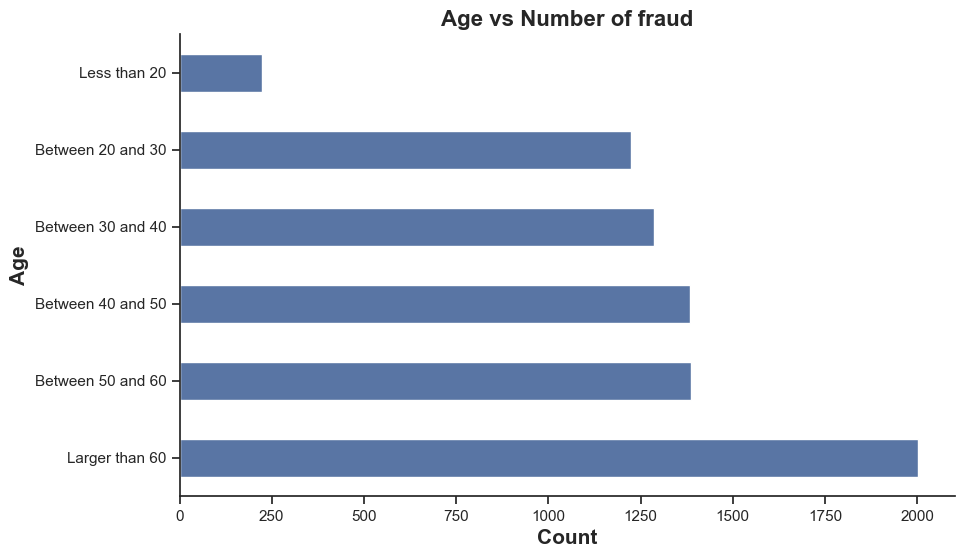

<Figure size 1000x600 with 0 Axes>

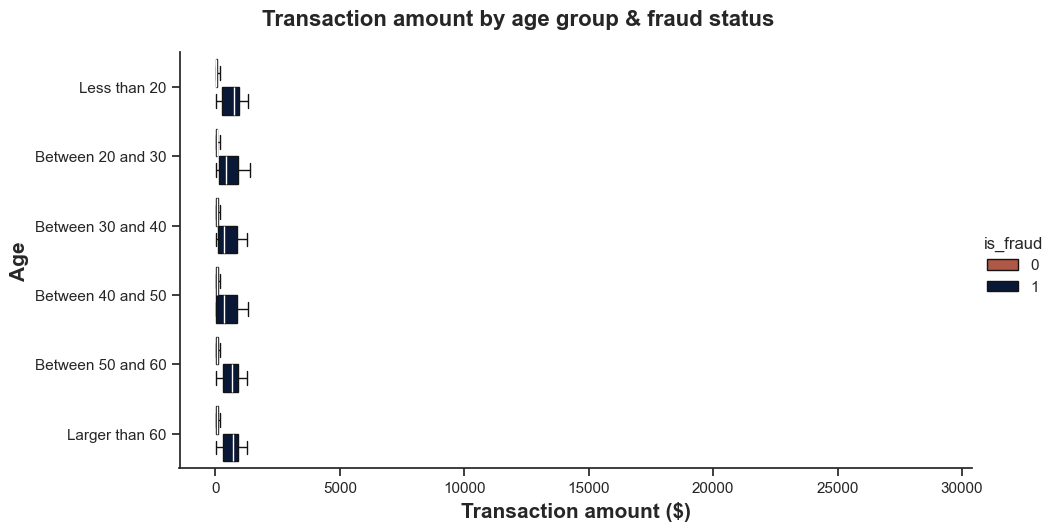

In [48]:
# Age vs Fraud count
plt.figure(figsize=(10,6))
sns.set_palette(["b"])
g = sns.countplot(y='age_intervals', data=df_fraud, order=age_order, width=0.5)
g.set_title('Age vs Number of fraud', fontdict={'fontsize':16, 'fontweight':'bold'})
g.set_xlabel('Count', fontsize=15, fontweight='bold')
g.set_ylabel('Age', fontsize=15, fontweight='bold')
plt.show()

# Transaction amount by age and fraud status
plt.figure(figsize=(10,6))
sns.set_palette(["#C04C36", "#00163E"])
g = sns.catplot(y='age_intervals', x="transaction_amount", data=df, hue='is_fraud',
                order=age_order, kind='box', medianprops={"color":"w"}, 
                flierprops={"marker": ""},
                width=0.8, aspect=2, legend=True)
g.fig.suptitle('Transaction amount by age group & fraud status', fontsize=16, fontweight='bold', y=1.05)
g.set_xlabels('Transaction amount ($)', fontsize=15, fontweight='bold')
g.set_ylabels('Age', fontsize=15, fontweight='bold')
plt.show()

# Transaction Analysis
Transaction Amount Distribution


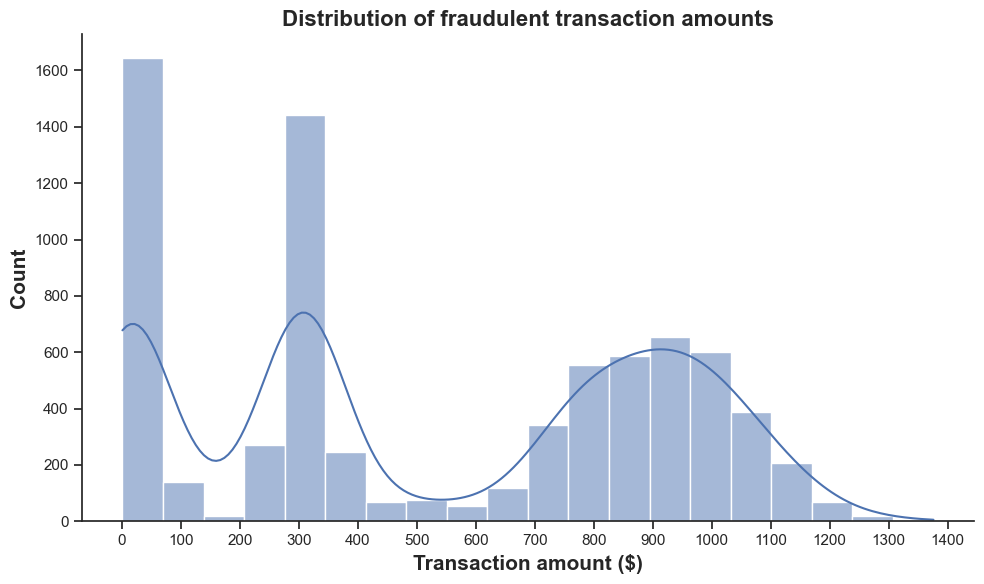

In [53]:
# Fraud transaction amount distribution
fig, ax = plt.subplots(figsize=(10,6))
sns.set_palette(["b"])
sns.histplot(df_fraud['transaction_amount'], kde=True, bins=20, ax=ax)
ax.set_title('Distribution of fraudulent transaction amounts', fontsize=16, fontweight='bold')
ax.set_xlabel('Transaction amount ($)', fontsize=15, fontweight='bold')
ax.set_ylabel('Count', fontsize=15, fontweight='bold')
ax.set_xticks(list(range(0, 1500,100)))
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

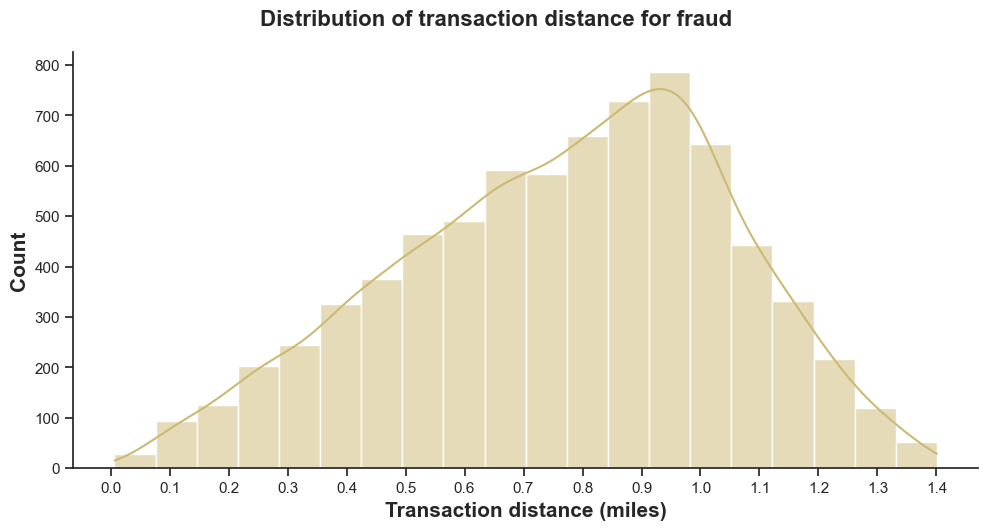

In [54]:
# Transaction distance for fraudulent transactions
plt.figure(figsize=(10,6))
sns.set_palette(["y"])
g = sns.displot(df_fraud['transaction_distance'], kde=True, bins=20, aspect=2)
g.fig.suptitle('Distribution of transaction distance for fraud', fontsize=16, fontweight='bold', y=1.05)
g.set_xlabels('Transaction distance (miles)', fontsize=15, fontweight='bold')
g.set_ylabels('Count', fontsize=15, fontweight='bold')
g.set(xticks=list(np.arange(0, 1.5, 0.1)))
plt.show()

# Temporal Analysis
Monthly Fraud Pattern

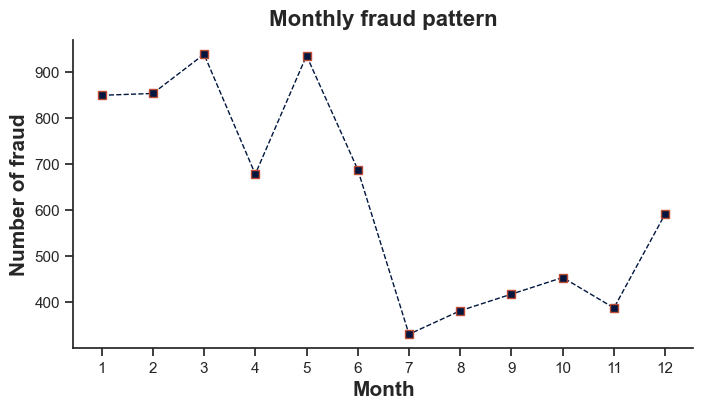

In [38]:
# Fraud by month
count_fraud_month_df_sort = df_fraud['transaction_month'].value_counts().sort_index()
plt.figure(figsize=(8,4))
plt.plot(count_fraud_month_df_sort.index, count_fraud_month_df_sort.values,
         linestyle='--', marker="s", color='#00163E', markeredgecolor="#C04C36", linewidth=1)
plt.xlabel("Month", weight='bold', fontsize=15)
plt.ylabel('Number of fraud', weight='bold', fontsize=15)
plt.title("Monthly fraud pattern", weight='bold', fontsize=16, y=1.02)
plt.xticks(range(1,13,1))
plt.show()

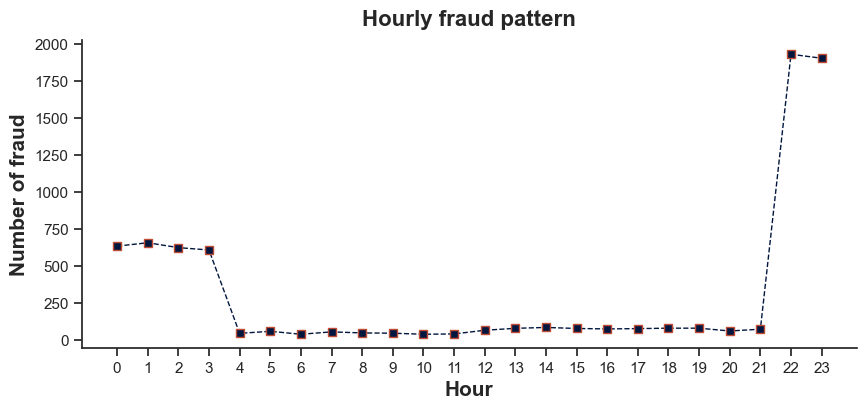

In [39]:
# Fraud by hour
count_fraud_hour_df_sort = df_fraud['transaction_hour'].value_counts().sort_index()
plt.figure(figsize=(10,4))
plt.plot(count_fraud_hour_df_sort.index, count_fraud_hour_df_sort.values,
         linestyle='--', marker="s", color='#00163E', markeredgecolor="#C04C36", linewidth=1)
plt.xlabel("Hour", weight='bold', fontsize=15)
plt.ylabel('Number of fraud', weight='bold', fontsize=15)
plt.title("Hourly fraud pattern", weight='bold', fontsize=16, y=1.02)
plt.xticks(range(0,24,1))
plt.show()

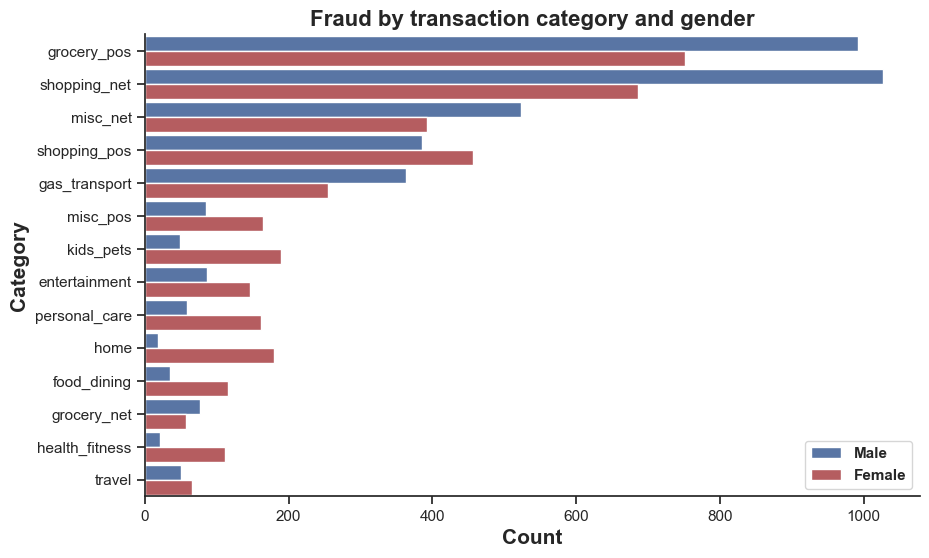

In [55]:
# Fraud by category and gender
plt.figure(figsize=(10,6))
sns.set_palette(["b", "r"])
g = sns.countplot(y='category', data=df_fraud, hue='gender', width=0.9,
                 order=df_fraud['category'].value_counts().index)
g.set_title('Fraud by transaction category and gender', fontdict={'fontsize':16, 'fontweight':'bold'})
g.set_xlabel('Count', fontsize=15, fontweight='bold')
g.set_ylabel('Category', fontsize=15, fontweight='bold')
g.legend(prop={'weight':'bold'})
plt.show()

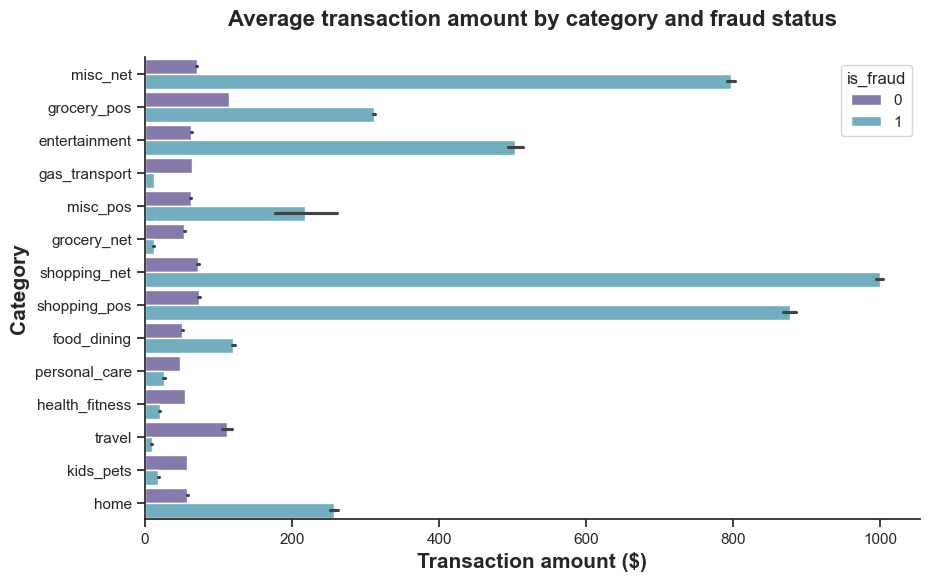

In [56]:
# Average transaction amount by category and fraud status
plt.figure(figsize=(10,6))
sns.set_palette(["m", "c"])
g = sns.barplot(data=df, x='transaction_amount', y='category', hue='is_fraud', width=0.9)
g.set_title('Average transaction amount by category and fraud status', fontsize=16, fontweight='bold', y=1.05)
g.set_xlabel('Transaction amount ($)', fontsize=15, fontweight='bold')
g.set_ylabel('Category', fontsize=15, fontweight='bold')
plt.show()

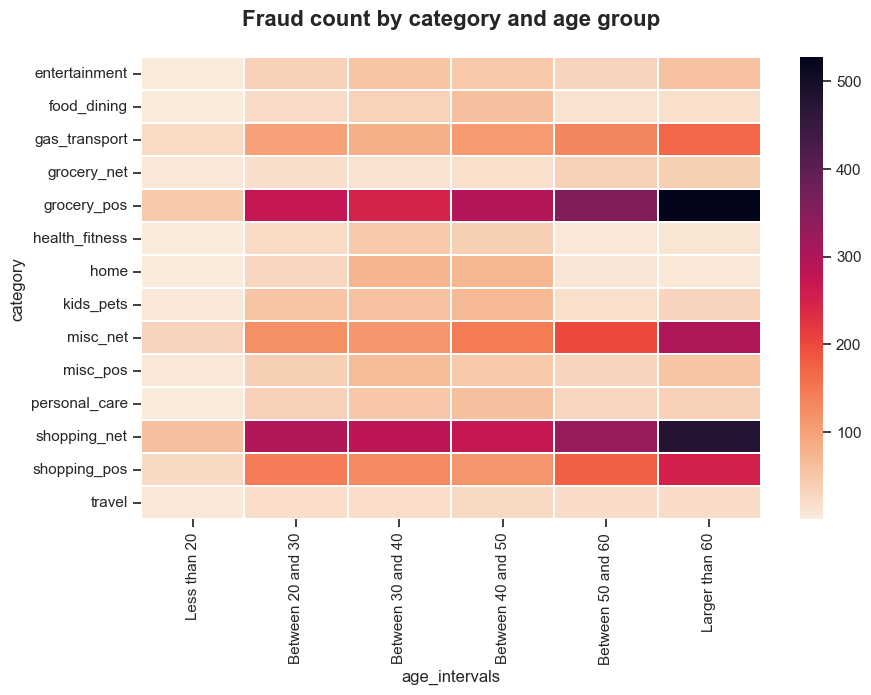

In [43]:
# Fraud heatmap (category vs age)
pd_crosstab = pd.crosstab(df_fraud["category"], df_fraud["age_intervals"])
pd_crosstab_ordered = pd_crosstab[age_order]
plt.figure(figsize=(10,6))
g = sns.heatmap(pd_crosstab_ordered, cbar=True, cmap='rocket_r', linewidths=0.3)
g.set_title('Fraud count by category and age group', fontsize=16, fontweight='bold', y=1.05)
plt.show()

# Geographic Analysis
Top Cities for Fraud

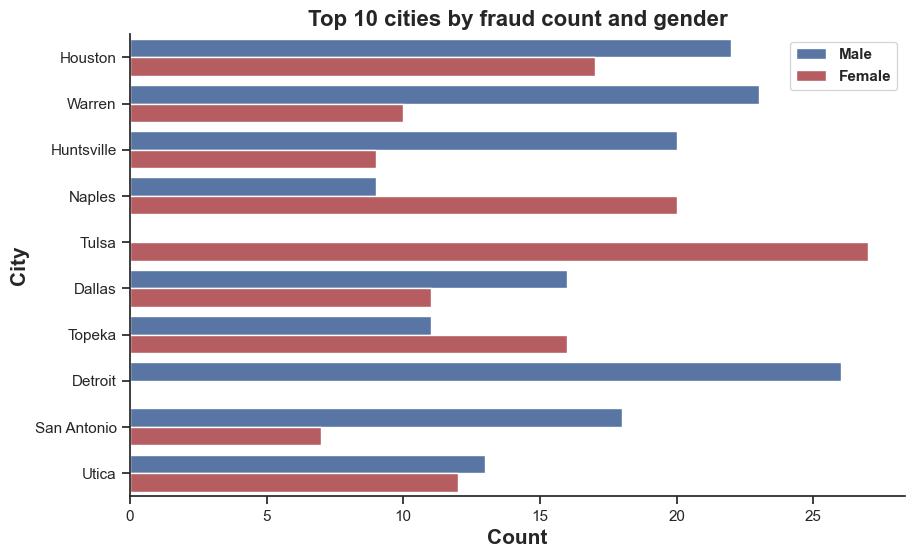

In [57]:
# Top cities for fraud
plt.figure(figsize=(10,6))
sns.set_palette(["b", "r"])
g = sns.countplot(y='city', data=df_fraud, hue='gender', width=0.8,
                 order=df_fraud['city'].value_counts().head(10).index)
g.set_title('Top 10 cities by fraud count and gender', fontdict={'fontsize':16, 'fontweight':'bold'})
g.set_xlabel('Count', fontsize=15, fontweight='bold')
g.set_ylabel('City', fontsize=15, fontweight='bold')
g.legend(prop={'weight':'bold'})
plt.show()